In [48]:
import numpy as np
import pandas as pd
import sys
sys.path.append('/home/capstone22/WildFIrePrediction/PwC-LSTM-Capstone-Project/src/')
from roc import plot_roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

Data Loading

In [49]:
'''
df_train = pd.read_csv('/home/capstone22/WildFIrePrediction/isaac_data/Isaac_data_original/isaac_train.csv')
df_valid = pd.read_csv('/home/capstone22/WildFIrePrediction/isaac_data/Isaac_data_original/isaac_valid.csv')
df_test = pd.read_csv('/home/capstone22/WildFIrePrediction/isaac_data/Isaac_data_original/isaac_test.csv')
'''

"\ndf_train = pd.read_csv('/home/capstone22/WildFIrePrediction/isaac_data/Isaac_data_original/isaac_train.csv')\ndf_valid = pd.read_csv('/home/capstone22/WildFIrePrediction/isaac_data/Isaac_data_original/isaac_valid.csv')\ndf_test = pd.read_csv('/home/capstone22/WildFIrePrediction/isaac_data/Isaac_data_original/isaac_test.csv')\n"

In [50]:
coords = pd.read_csv('/home/capstone22/WildFIrePrediction/isaac_data/LatLon.csv')

In [51]:
df_train = pd.DataFrame()

for i in range(2003,2014):
    PATH = '/home/capstone22/WildFIrePrediction/isaac_data/Isaac_data_original/'
    CD_PATH = PATH + 'CD_' + str(i) + '_' + str(i) + '.csv'
    TD_PATH = PATH + 'TD_' + str(i) + '_' + str(i) + '.csv'
    
    df_temp = pd.read_csv(CD_PATH)
    df_temp = df_temp.loc[coords['pixel_id']]

    gt_temp = pd.read_csv(TD_PATH)
    gt_temp = gt_temp.loc[coords['pixel_id']]

    df_temp['value'] = gt_temp['value']

    df_train = df_train.append(df_temp)

df_train = shuffle(df_train)

df_train.info

<bound method DataFrame.info of          pixel_id  pixel_id.1   Road_Dist  Elec_Dist  Cultivated_Prop    Elev  \
387029     387029      387029  15811.3890   7.000000              0.0  1199.0   
1049941   1049941     1049941   6708.2040   8.485281              0.0   210.0   
1050835   1050835     1050835   2828.4272   3.162278              0.0   831.0   
1054598   1054598     1054598      0.0000   0.000000              0.0   829.0   
834380     834380      834380  46529.5600  19.849434              0.0   963.0   
...           ...         ...         ...        ...              ...     ...   
544028     544028      544028   2828.4272   6.324555              0.0   135.0   
320244     320244      320244   8944.2710   8.944272              0.0  2221.0   
779541     779541      779541   5000.0000   5.000000              1.0    63.0   
1048168   1048168     1048168  17804.4940  17.720045              0.0   394.0   
181770     181770      181770   7615.7730   6.324555              0.0  1296.0

In [52]:
dataframes = []
groundTruth = []

for i in range(2014, 2018):
    PATH = '/home/capstone22/WildFIrePrediction/isaac_data/Isaac_data_original/'
    CD_PATH = PATH + 'CD_' + str(i) + '_' + str(i) + '.csv'
    TD_PATH = PATH + 'TD_' + str(i) + '_' + str(i) + '.csv'

    df = pd.read_csv(CD_PATH)
    gt = pd.read_csv(TD_PATH)

    df = df.loc[coords['pixel_id']]
    gt = gt.loc[coords['pixel_id']]

    dataframes.append(df)
    groundTruth.append(gt['value'])

Feature Selection

In [59]:
'''
selected_features = ['Road_Dist',
                    'Elec_Dist',
                    'Cultivated_Prop',
                    'aet__maximum_Normal',
                    'aet__mean_Normal',
                    'aet__minimum_Normal',
                    'cwd__maximum_Normal',
                    'cwd__mean_Normal',
                    'cwd__minimum_Normal',
                    'pck__maximum_Normal',
                    'pck__mean_Normal',
                    'pck__minimum_Normal',
                    'aet__mean_ThreeYear_Dev',
                    'cwd__mean_ThreeYear_Dev',
                    'Mean_Housing_Dens_25km',
                    'FFWI',
                    'time_since_fire']
'''

selected_features = ['Elec_Dist',
                    'aet__mean_Normal',
                    'aet__mean_ThreeYear_Dev',
                    'cwd__mean_Normal',
                    'cwd__mean_ThreeYear_Dev',
                    'FFWI',
                    'time_since_fire']



Model

In [60]:
X_train = df_train[selected_features]
y_train = df_train['value']

In [61]:
clf = LogisticRegression().fit(X_train, y_train)

/home/capstone22/WildFIrePrediction/venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [79]:
predictions = []

for df in dataframes:
    X = df[selected_features]
    pred = clf.predict(X)
    pred_prob = clf.predict_proba(X)
    pred_prob = np.clip(pred_prob, 0, 0.1)
    fire_prob = pred_prob[:, 1]
    predictions.append(fire_prob)

In [80]:
print(max(predictions[0]))

0.1


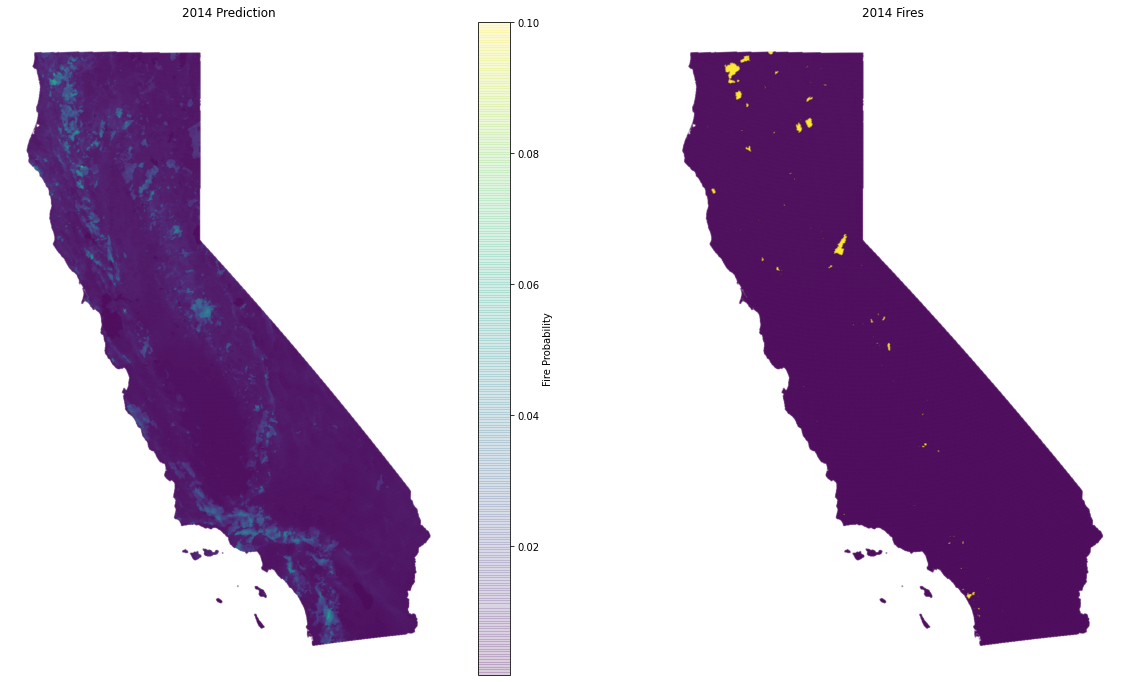

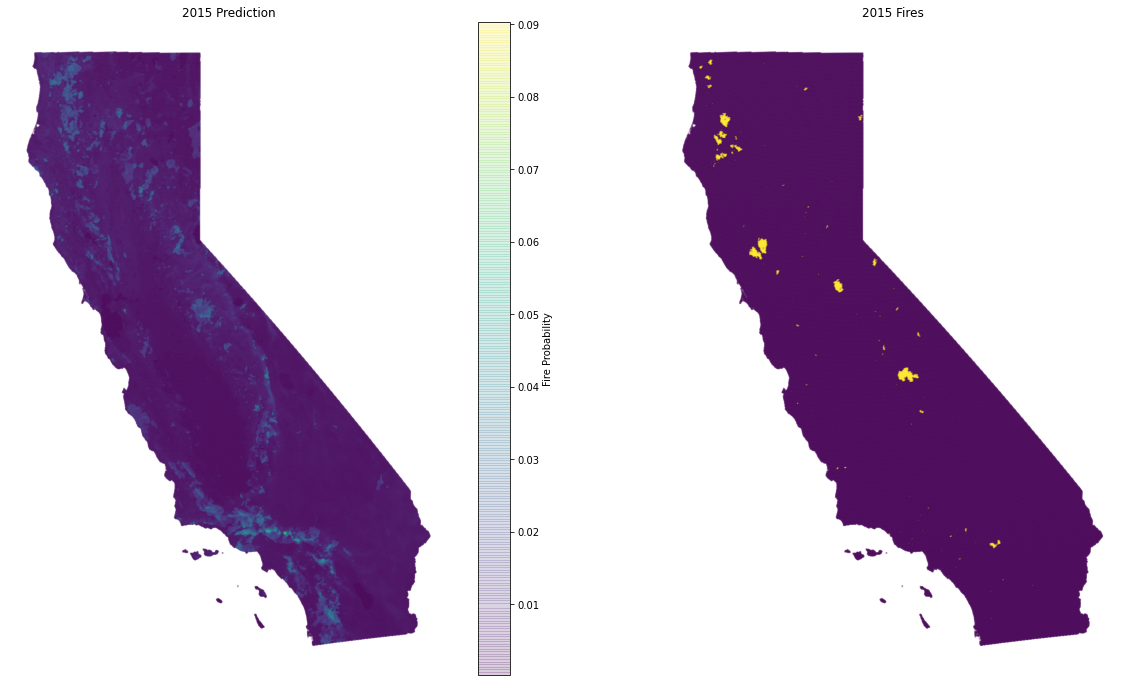

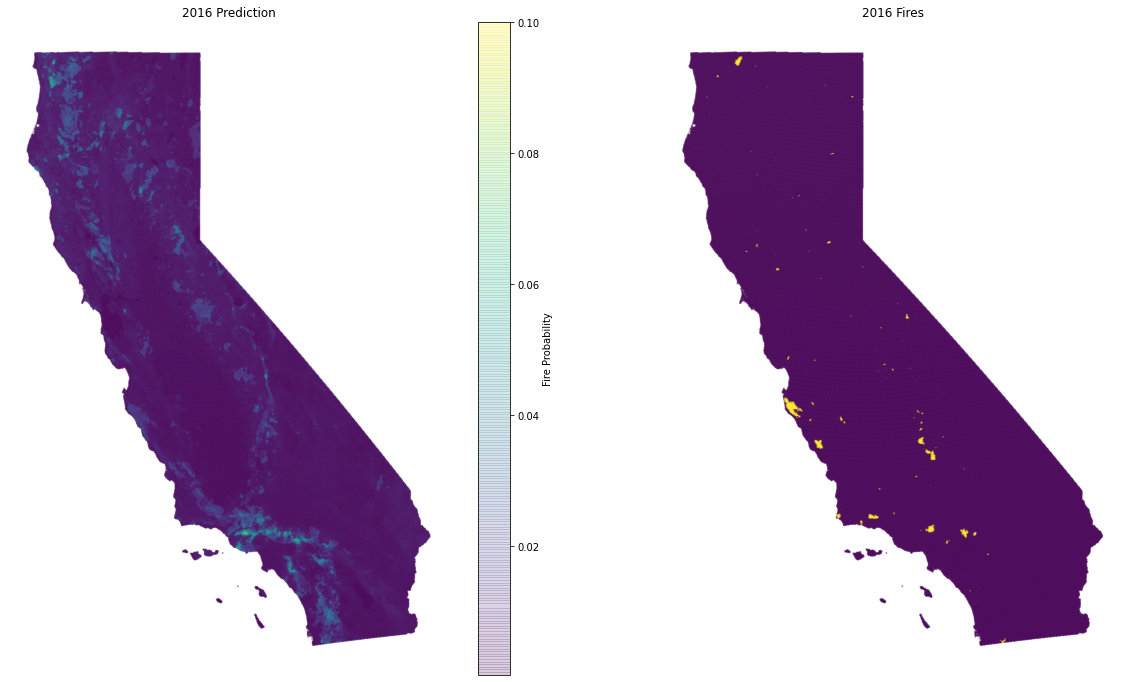

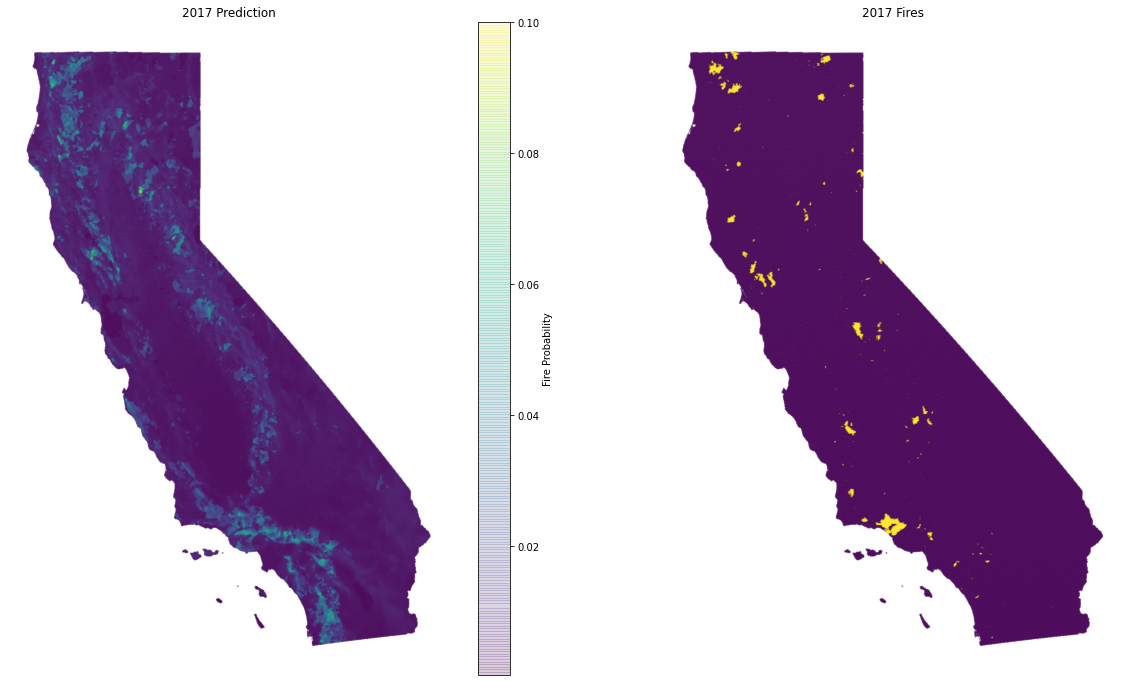

In [81]:
year = 2014
for i in range(len(predictions)):
    year = 2014 + i

    fig, axs = plt.subplots(1,2, gridspec_kw={'width_ratios': [6,5]}, figsize = (20, 12))
    
    probHeatmap = axs[0].scatter(coords['Longitude'], coords['Latitude'], alpha = 0.2, s = 1, c = predictions[i])
    axs[0].set_title(str(year) + ' Prediction')
    axs[0].axis('off')

    truthHeatmap = axs[1].scatter(coords['Longitude'], coords['Latitude'], alpha = 0.2, s = 1, c = groundTruth[i])
    axs[1].set_title(str(year) + ' Fires')
    axs[1].axis('off')


    fig.colorbar(probHeatmap, ax = axs[0], label="Fire Probability", orientation="vertical")

    plt.show()
